# Summary

-----

# Imports

In [1]:
NOTEBOOK_NAME = 'core_to_calculate'

In [2]:
%run imports.ipynb

elaspic_training_set
2016-05-25 17:59:41.249596


/home/kimlab1/strokach/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load data

In [3]:
db = datapkg.DataFrameToMySQL(CONNECTION_STR, NOTEBOOK_NAME, STG_SERVER_IP, echo=False)

In [4]:
with open('load_data/data.pkl', 'rb') as ifh:
    DATA = pickle.load(ifh)

In [5]:
DATA['taipale'].head()

,uniprot_id,uniprot_mutation,ddg_exp,uniprot_sequence,pfam_clan,alignment_identity,alignment_coverage,alignment_score,norm_dope,matrix_score,secondary_structure_wt,solvent_accessibility_wt,secondary_structure_change,solvent_accessibility_change,provean_score,ddg,dg_wt,backbone_hbond_wt,sidechain_hbond_wt,van_der_waals_wt,electrostatics_wt,solvation_polar_wt,solvation_hydrophobic_wt,van_der_waals_clashes_wt,entropy_sidechain_wt,entropy_mainchain_wt,sloop_entropy_wt,mloop_entropy_wt,cis_bond_wt,torsional_clash_wt,backbone_clash_wt,helix_dipole_wt,water_bridge_wt,disulfide_wt,electrostatic_kon_wt,partial_covalent_bonds_wt,energy_ionisation_wt,entropy_complex_wt,number_of_residues,dg_change,backbone_hbond_change,sidechain_hbond_change,van_der_waals_change,electrostatics_change,solvation_polar_change,solvation_hydrophobic_change,van_der_waals_clashes_change,entropy_sidechain_change,entropy_mainchain_change,sloop_entropy_change,mloop_entropy_change,cis_bond_change,torsional_clash_change,backbone_clash_change,helix_dipole_change,water_bridge_change,disulfide_change,electrostatic_kon_change,partial_covalent_bonds_change,energy_ionisation_change,entropy_complex_change,pcv_salt_equal_wt,pcv_salt_equal_self_wt,pcv_salt_equal_change,pcv_salt_equal_self_change,pcv_salt_opposite_wt,pcv_salt_opposite_self_wt,pcv_salt_opposite_change,pcv_salt_opposite_self_change,pcv_hbond_wt,pcv_hbond_self_wt,pcv_hbond_change,pcv_hbond_self_change,pcv_vdw_wt,pcv_vdw_self_wt,pcv_vdw_change,pcv_vdw_self_change
0,A4Z6T7,G286E,0.387622,MDIEAYFERIGYKNSRNKLDLETLTDILEHQIRAVPFENLNMHCGQ...,Acetyltransf_2,99.65,100.0,0.996675,-1.51582,-3.0,7.0,28.58110,0,20.79520,0.176,0.400170,38.5534,-194.852,-85.2952,-369.111,-10.52370,479.627,-492.498,44.0919,199.524,441.105,0.0,0.0,0.0,34.1418,177.513,-9.19542,0.0,0.0,0.0,0.0,1.53934,0.0,290.0,6.0769,0.762,0.7618,-0.939,0.14080,1.334,-1.210,2.2125,-0.235,2.417,0.0,0.0,0.0,1.0366,0.423,0.00000,0.0,0.0,0.0,0.0,-0.204400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A4Z6T7,Q145P,2.421890,MDIEAYFERIGYKNSRNKLDLETLTDILEHQIRAVPFENLNMHCGQ...,Acetyltransf_2,99.65,100.0,0.996675,-1.51582,-2.0,2.0,10.46140,1,3.18620,-5.800,1.465550,37.8203,-194.561,-83.6919,-368.990,-10.52320,479.233,-492.495,43.9700,197.813,441.104,0.0,0.0,0.0,33.6173,177.478,-9.19471,0.0,0.0,0.0,0.0,1.53934,0.0,290.0,5.5316,2.266,1.3876,1.119,0.00090,-2.078,0.471,3.9582,-1.520,0.170,0.0,0.0,0.0,-0.2435,-0.289,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,46.0,0.0,0.0
2,A4Z6T7,R64Q,1.113730,MDIEAYFERIGYKNSRNKLDLETLTDILEHQIRAVPFENLNMHCGQ...,Acetyltransf_2,99.65,100.0,0.996675,-1.51582,1.0,0.0,2.93349,0,4.37984,-3.547,-0.564750,38.5226,-194.823,-84.1151,-368.733,-10.46730,478.871,-492.228,43.5601,198.650,441.181,0.0,0.0,0.0,34.3242,177.520,-9.24309,0.0,0.0,0.0,0.0,1.54633,0.0,290.0,-0.4996,-0.647,0.3541,0.828,1.84412,-2.328,0.579,-0.6045,-0.024,-0.260,0.0,0.0,0.0,-0.4652,0.167,0.21582,0.0,0.0,0.0,0.0,0.007670,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,0.0,0.0
3,A4Z6T7,Y208H,2.273714,MDIEAYFERIGYKNSRNKLDLETLTDILEHQIRAVPFENLNMHCGQ...,Acetyltransf_2,99.65,100.0,0.996675,-1.51582,2.0,4.0,48.07450,0,-13.31430,-2.582,0.073803,38.6287,-194.868,-85.1879,-369.129,-10.52220,479.709,-492.519,44.0835,199.520,441.104,0.0,0.0,0.0,34.0950,177.510,-9.19471,0.0,0.0,0.0,0.0,1.53934,0.0,290.0,0.5161,0.015,-0.2935,-0.018,0.00000,0.329,0.155,-0.0031,0.197,0.080,0.0,0.0,0.0,0.0046,-0.005,0.00000,0.0,0.0,0.0,0.0,0.048790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,31.0,0.0,0.0
4,P11245,G286E,0.387622,MDIEAYFERIGYKNSRNKLDLETLTDILEHQIRAVPFENLNMHCGQ...,Acetyltransf_2,100.00,100.0,1.000000,-1.41174,-3.0,7.0,20.70860,0,16.34790,0.142,0.570211,49.1354,-191.260,-81.3950,-369.226,-9.64026,476.543,-490.719,46.9388,194.127,440.426,0.0,0.0,0.0,42.4260,176.273,-10.09760,0.0,0.0,0.0,0.0,1.01351,0.0,290.0,5.9710,0.673,0.6729,-1.604,0.16552,2.206,-2.091,2.3823,0.160,2.441,0.0,0.0,0.0,1.1581,0.743,0.00000,0.0,0.0,0.0,

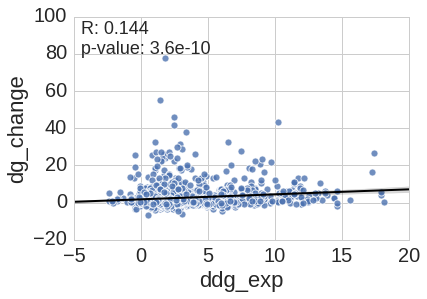

In [6]:
# Some validation to make sure that we 
fg, ax = plt.subplots()
ascommon.plotting.make_plot_with_corr(x='ddg_exp', y='dg_change', data=DATA['taipale'], ax=ax, corr_type='pearson')

In [7]:
def get_elaspic_to_calculate(df):
    sql_query = """\
select uniprot_id, uniprot_domain_id, domain_def, model_domain_def
from elaspic.uniprot_domain
join elaspic.uniprot_domain_template using (uniprot_domain_id)
join elaspic.uniprot_domain_model using (uniprot_domain_id)
where uniprot_id in ('{}');
""".format("', '".join(set(df['uniprot_id'].dropna().values)))
    uniprot_domain_model = pd.read_sql_query(sql_query, db.engine)
    df = df.merge(uniprot_domain_model, on=['uniprot_id'])
    df 
    mutation_in_domain_ = (
        df
        [['uniprot_mutation', 'domain_def']]
        .apply(lambda x: ascommon.sequence_tools.mutation_in_domain(*x), axis=1)
    )
    # 
    mutation_in_model_domain_ = (
        df
        [['uniprot_mutation', 'model_domain_def']]
        .apply(lambda x: ascommon.sequence_tools.mutation_in_domain(*x), axis=1)
    )
    # 
    to_calculate = (
        df[
            (df['ddg'].isnull()) & 
            (mutation_in_model_domain_ | (mutation_in_domain_ & mutation_in_model_domain_.isnull()))
        ]
        [['uniprot_id', 'uniprot_mutation']]
        .drop_duplicates()
    )
    return to_calculate

In [8]:
to_calculate_all = {}
for table_name in DATA:
    to_calculate_all[table_name] = get_elaspic_to_calculate(DATA[table_name])
    print("{}: {}".format(table_name, to_calculate_all[table_name].shape[0]))

alascan_gpk: 4
uniprot: 1324
potapov: 15
protherm: 25
curatedprotherm: 18
taipale: 47
kellogg: 4
guerois: 4


In [9]:
to_calculate = pd.concat(to_calculate_all.values(), ignore_index=True)

In [10]:
print(to_calculate.shape[0])
# 2259

1441


In [11]:
to_calculate = to_calculate.drop_duplicates()

In [12]:
print(to_calculate.shape[0])
# 1366

1366


# Stats

In [13]:
columns = sorted(DATA.keys())
df = pd.DataFrame(columns=columns, index=columns, dtype=float)
counts = {}
for table_name_1, df_1 in DATA.items():
    df_1 = df_1.dropna(subset=['ddg', 'ddg_exp'])  # Plot only calculated mutations
    mutation_set_1 = set(df_1['uniprot_id'] + '.' + df_1['uniprot_mutation'])
    counts[table_name_1] = len(mutation_set_1)
    for table_name_2, df_2 in DATA.items():
        df_2 = df_2.dropna(subset=['ddg'])  # xxx
        mutation_set_2 = set(df_2['uniprot_id'] + '.' + df_2['uniprot_mutation'])
        frac_covered = 1 - len(mutation_set_1 - mutation_set_2) / len(mutation_set_1)
        df.loc[table_name_1, table_name_2] = frac_covered * 100.0
df.index = ['{}\n(n = {:.0f})'.format(x, counts[x]) for x in df.index]

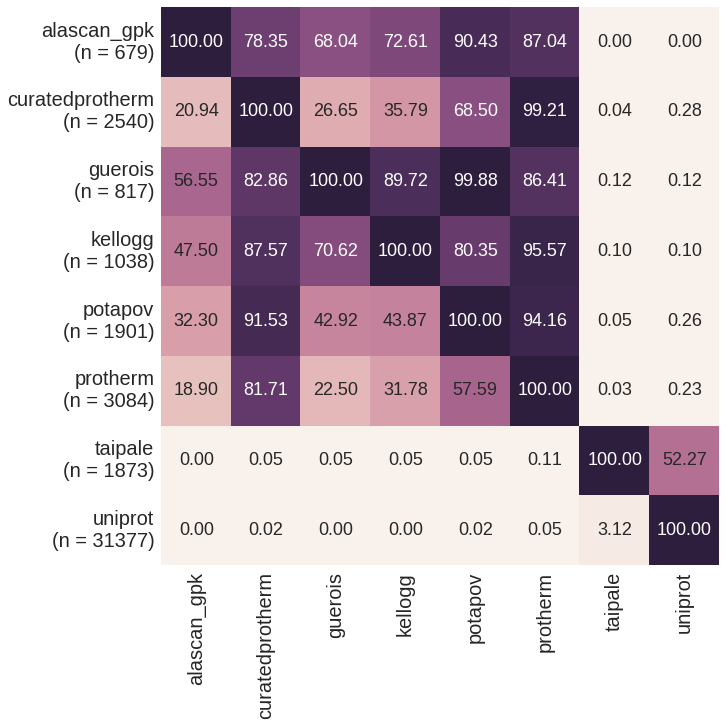

In [14]:
fg, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df, annot=True, fmt=".2f", ax=ax, square=True, cbar=False, annot_kws={"size": 18})

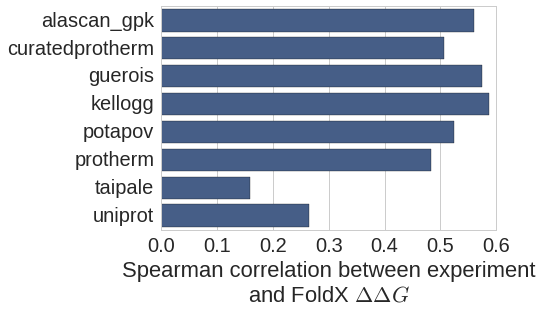

In [15]:
corrs = {}
for table_name, df in DATA.items():
    tmp = df[df[['ddg_exp', 'dg_change']].notnull().all(axis=1)]
    corrs[table_name] = sp.stats.spearmanr(tmp['ddg_exp'], tmp['dg_change'])[0]
corrs = pd.Series(corrs)

fg, ax = plt.subplots()
x = sns.barplot(corrs.values, corrs.index, ax=ax, color=sns.xkcd_rgb["denim blue"])
ax.set_xlabel('Spearman correlation between experiment\nand FoldX $\Delta \Delta G$')

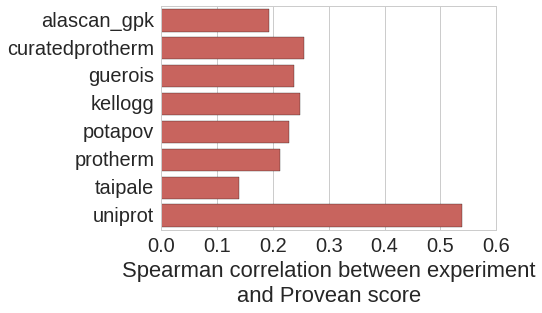

In [16]:
corrs = {}
for table_name, df in DATA.items():
    tmp = df[df[['ddg_exp', 'provean_score']].notnull().all(axis=1)]
    corrs[table_name] = - sp.stats.spearmanr(tmp['ddg_exp'], tmp['provean_score'])[0]
corrs = pd.Series(corrs)

fg, ax = plt.subplots()
x = sns.barplot(corrs.values, corrs.index, ax=ax, color=sns.xkcd_rgb["pale red"])
ax.set_xlabel('Spearman correlation between experimental $\Delta \Delta G$ and\nProvean score (negative)')
plt.xlim(0, 0.6)
ax.set_xlabel('Spearman correlation between experiment\nand Provean score')

## Divide into Structure, Taipale and Sequence datasets

# Save

In [17]:
os.makedirs(NOTEBOOK_NAME, exist_ok=True)

In [18]:
to_calculate.to_csv(op.join(NOTEBOOK_NAME, 'elaspic_to_calculate.tsv'), sep='\t', index=False)

In [19]:
to_calculate.shape

(1366, 2)

In [20]:
!head $NOTEBOOK_NAME/elaspic_to_calculate.tsv

uniprot_id	uniprot_mutation
P61626	S54A
P61626	T61A
P24821	P806A
P24821	P826A
Q86V21	I118V
Q86V21	A470V
O00763	I552V
O00763	A651T
Q9NPH0	V316M
